In [1]:
import os
print(os.listdir("../input"))

['dysarthric-spectrogram']


In [2]:
train_ds ="/kaggle/input/dysarthric-spectrogram/split_data/train"
val_ds = "/kaggle/input/dysarthric-spectrogram/split_data/val"
test_ds = "/kaggle/input/dysarthric-spectrogram/split_data/test"

In [3]:
import os
import cv2
import numpy as np

def load_spectrogram_images(directory):
    spectrogram_images = []
    labels = []

    for word_folder in os.listdir(directory):
        word_path = os.path.join(directory, word_folder)
        if os.path.isdir(word_path):
            for image_file in os.listdir(word_path):
                image_path = os.path.join(word_path, image_file)
                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                spectrogram_images.append(img)
                labels.append(word_folder)

    return np.array(spectrogram_images), np.array(labels)

train_images, train_labels = load_spectrogram_images(train_ds)
val_images, val_labels = load_spectrogram_images(val_ds)
test_images, test_labels = load_spectrogram_images(test_ds)


In [4]:
print(len(train_labels))
print(len(test_labels))
print(len(val_labels))

11160
1395
1395


In [5]:
len(train_images)

11160

In [6]:
train_images[71]

array([[ 79,  78,  80, ..., 108, 108, 108],
       [ 77,  78,  80, ..., 107, 106, 109],
       [ 80,  80,  78, ..., 107, 107, 110],
       ...,
       [110, 110, 114, ..., 118, 115, 117],
       [113, 114, 111, ..., 118, 118, 118],
       [112, 110, 111, ..., 117, 117, 116]], dtype=uint8)

In [7]:
train_labels[71]

'part'

In [8]:
import numpy.ma as ma
ma.shape(train_images[71])

(432, 576)

In [9]:
import numpy as np
import librosa
import pywt

# Capture the shape of the spectral envelope.
def extract_mfcc_from_spectrogram(spectrogram_image):
    # Compute MFCC features directly from the spectrogram image
    mfcc = librosa.feature.mfcc(S=spectrogram_image, sr=44100, n_mfcc=13)  # Adjust sr if needed

    return mfcc

# spectral info of a pixel distribution across frequencies
def wavelet_transform(image):
    coeffs = pywt.wavedec2(image, 'haar', level=5)
    return coeffs

#Represents the center of mass of the spectral distribution.
def extract_spectral_centroid(spectrogram_image):
    # Compute spectral centroid
    spectral_centroid = librosa.feature.spectral_centroid(S=spectrogram_image)

    return spectral_centroid

# Frequency below which a specified percentage of the total spectral energy lies.
def extract_spectral_rolloff(spectrogram_image):
    # Compute spectral roll-off
    spectral_rolloff = librosa.feature.spectral_rolloff(S=spectrogram_image)

    return spectral_rolloff

# Measures the change in spectral content between consecutive frames.
def extract_spectral_flux(spectrogram_image):
    # Compute spectral flux
    spectral_flux = librosa.onset.onset_strength(S=spectrogram_image)

    return spectral_flux

# Similar to spectral flux but computed in the time domain.
def compute_temporal_flux(spectrogram_image, frame_duration):
    # Compute temporal flux
    temporal_flux = []
    for t in range(1, spectrogram_image.shape[1]):
        delta_energy = spectrogram_image[:, t] - spectrogram_image[:, t - 1]
        flux_t = delta_energy / frame_duration
        temporal_flux.append(flux_t)
    return temporal_flux


In [10]:
import librosa
import pywt
import numpy as np

def spectrogram_features(spectrogram_image, frame_duration=0.01):
    # Normalize the spectrogram image (assuming it's in the range [0, 255])
    spectrogram_image = spectrogram_image / 255.0

    # Compute MFCC features
    mfcc = librosa.feature.mfcc(S=spectrogram_image, sr=44100, n_mfcc=13)

    # Compute wavelet transform coefficients
    #wavelet_coeffs = wavelet_transform(spectrogram_image)

    # Flatten wavelet coefficients
    #flattened_wavelet_coeffs = np.concatenate([coeff.ravel() for coeff in wavelet_coeffs])

    # Compute spectral centroid
    spectral_centroid = librosa.feature.spectral_centroid(S=spectrogram_image)

    # Compute spectral roll-off
    spectral_rolloff = librosa.feature.spectral_rolloff(S=spectrogram_image)

    # Compute spectral flux
    spectral_flux = librosa.onset.onset_strength(S=spectrogram_image)

    # Compute temporal flux
    temporal_flux = []
    for t in range(1, spectrogram_image.shape[1]):
        delta_energy = spectrogram_image[:, t] - spectrogram_image[:, t - 1]
        flux_t = delta_energy / frame_duration
        temporal_flux.append(flux_t)

    # Combine all features into a single array
    features = np.concatenate([mfcc.ravel(), 
                               spectral_centroid.ravel(), spectral_rolloff.ravel(),
                               spectral_flux.ravel()] + temporal_flux, axis=None)

    return features

# Example usage:
spectrogram_image = train_images[0]  # Replace with your actual spectrogram image
feature_vector = spectrogram_features(spectrogram_image)


In [11]:
no_of_samples = 2000

In [12]:
#6 - Extracting the thermal features for each image
spectral_features = []
for img in train_images[:no_of_samples]:
    feature_vector = spectrogram_features(img)
    spectral_features.append(feature_vector)

#7 - Convert features to a numpy array
features = np.array(spectral_features)   

In [13]:
labels = train_labels[:no_of_samples]

In [14]:
features.shape

(2000, 257616)

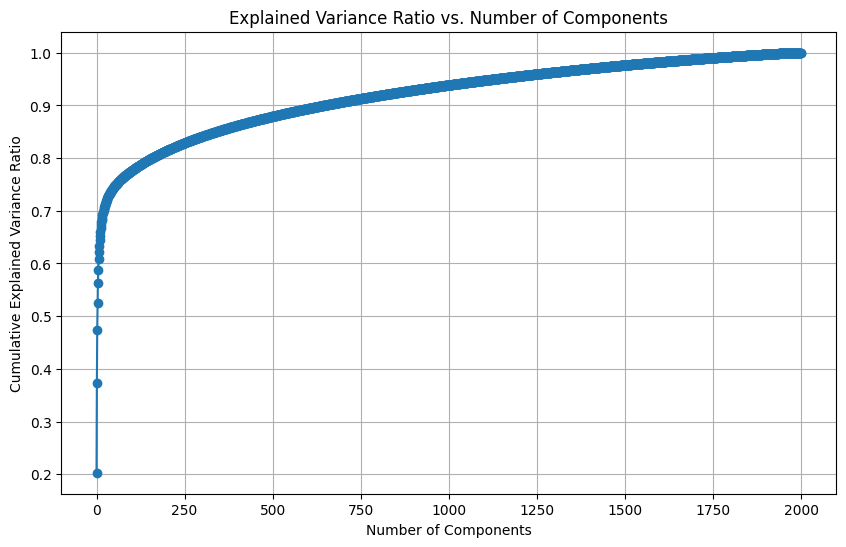

In [15]:
from sklearn.decomposition import PCA

# Initialize PCA
pca = PCA()

# Fit PCA to your features
pca.fit(features)

# Plot the explained variance ratio
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()


In [16]:
from sklearn.decomposition import PCA

# Initialize PCA
pca = PCA()

# Fit PCA to your features
pca.fit(features)

# Find the number of components to capture 94% of the variance
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components_94_variance = np.argmax(cumulative_variance_ratio >= 0.95) + 1

print("Number of components to capture 95% of the variance:", num_components_94_variance)
reduced_features = pca.fit_transform(features)
reduced_features.shape

Number of components to capture 95% of the variance: 1131


(2000, 2000)

In [17]:
from sklearn.decomposition import PCA

# Convert features_list to a 2D array where each row represents a sample and each column represents a feature
features_matrix = np.array(features)

# Initialize PCA
pca = PCA()

# Fit PCA to your features
pca.fit(features_matrix)

# Find the number of components to capture 95% of the variance
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components_95_variance = np.argmax(cumulative_variance_ratio >= 0.95) + 1

print("Number of components to capture 95% of the variance:", num_components_95_variance)

# Transform the features to the reduced-dimensional space
reduced_features = pca.transform(features_matrix)
print("Shape of reduced features:", reduced_features.shape)


Number of components to capture 95% of the variance: 1131
Shape of reduced features: (2000, 2000)


In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reduced_features, labels, test_size=0.2, random_state=42)

# Train the SVM classifier with RBF kernel
svm_classifier = SVC(kernel='rbf', gamma='scale', C=3.0) 
svm_classifier.fit(X_train, y_train)

# Make predictions on the testing data
svm_predictions = svm_classifier.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, svm_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.715


In [19]:
svm_predictions

array(['more', 'he', 'no', 'Two', 'Yankee', 'Yankee', 'I', 'it', 'part',
       'way', 'part', 'we', 'will', 'he', 'way', 'call', 'than', 'Alt',
       'Alt', 'more', 'many', 'Five', 'that', 'way', 'than', 'come',
       'and', 'I', 'way', 'part', 'that', 'Right', 'no', 'Two', 'will',
       'it', 'he', 'Yankee', 'its', 'call', 'come', 'Nine', 'call',
       'that', 'so', 'way', 'more', 'Two', 'part', 'than', 'its', 'call',
       'other', 'Yankee', 'Two', 'write', 'Yankee', 'Five', 'and', 'we',
       'no', 'Two', 'Alt', 'more', 'Right', 'more', 'he', 'so', 'come',
       'other', 'other', 'we', 'each', 'its', 'than', 'he', 'Alt', 'it',
       'we', 'more', 'he', 'he', 'other', 'so', 'Five', 'other', 'write',
       'Alt', 'call', 'Alt', 'so', 'write', 'not', 'he', 'Nine', 'more',
       'many', 'Yankee', 'other', 'Nine', 'Two', 'way', 'we', 'each',
       'call', 'Two', 'that', 'Yankee', 'that', 'no', 'more', 'each',
       'its', 'many', 'than', 'we', 'will', 'I', 'Alt', 'Alt', 'mor

In [20]:
y_test

array(['more', 'he', 'Four', 'Two', 'Yankee', 'Yankee', 'I', 'write',
       'part', 'Four', 'part', 'Yankee', 'will', 'that', 'we', 'call',
       'than', 'come', 'Alt', 'more', 'many', 'Five', 'Right', 'will',
       'Nine', 'come', 'and', 'I', 'way', 'part', 'that', 'I', 'no',
       'Two', 'will', 'it', 'Alt', 'Yankee', 'its', 'call', 'come',
       'Nine', 'call', 'that', 'so', 'way', 'no', 'Two', 'part', 'Alt',
       'so', 'call', 'other', 'not', 'Two', 'write', 'Yankee', 'Five',
       'and', 'we', 'other', 'many', 'Alt', 'will', 'Right', 'more', 'I',
       'so', 'come', 'other', 'other', 'we', 'each', 'its', 'than', 'he',
       'Alt', 'than', 'we', 'more', 'part', 'way', 'other', 'so', 'Five',
       'other', 'write', 'it', 'call', 'Alt', 'so', 'write', 'not', 'he',
       'Nine', 'more', 'many', 'Yankee', 'other', 'Nine', 'Two', 'I',
       'we', 'each', 'call', 'Two', 'that', 'call', 'that', 'no', 'than',
       'each', 'its', 'write', 'than', 'we', 'will', 'I', 'he', 'Alt

In [21]:
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
print(classification_report(y_test, svm_predictions))

              precision    recall  f1-score   support

         Alt       0.67      0.67      0.67        18
        Five       1.00      0.73      0.85        15
        Four       0.62      0.73      0.67        11
           I       0.90      0.69      0.78        13
        Nine       0.94      0.85      0.89        20
       Right       0.50      0.33      0.40         9
         Two       0.77      0.83      0.80        12
      Yankee       0.73      0.73      0.73        15
         and       0.82      0.82      0.82        11
        call       0.62      0.87      0.72        15
        come       0.77      0.77      0.77        13
        each       1.00      1.00      1.00        13
          he       0.50      0.63      0.56        19
          it       0.76      0.87      0.81        15
         its       0.75      1.00      0.86         9
        many       0.47      0.78      0.58         9
        more       0.68      1.00      0.81        13
          no       0.73    

In [23]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression classifier
lr_classifier = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model to your features and labels
lr_classifier.fit(X_train, y_train)

# Make predictions
lr_predictions = lr_classifier.predict(X_test)
accuracy = accuracy_score(y_test, lr_predictions)
print("Accuracy:", accuracy)


Accuracy: 0.7625


In [24]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=1)

# Fit the model to your features and labels
knn_classifier.fit(X_train, y_train)

# Make predictions
knn_predictions = knn_classifier.predict(X_test)
accuracy = accuracy_score(y_test, knn_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.815


In [25]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Fit the model to your features and labels
gb_classifier.fit(X_train, y_train)

# Make predictions
gb_predictions = gb_classifier.predict(X_test)
accuracy = accuracy_score(y_test, gb_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.0875


In [34]:
# @title Classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reduced_features, labels, test_size=0.2, random_state=42)

# Dictionary to store classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(kernel='rbf', gamma='scale', C=3.0),
    'Gaussian Naive Bayes': GaussianNB()
}

# Train and evaluate each classifier
for clf_name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{clf_name} Accuracy:", accuracy)


Logistic Regression Accuracy: 0.7625
Decision Tree Accuracy: 0.1425
Random Forest Accuracy: 0.225
Support Vector Machine Accuracy: 0.715
Gaussian Naive Bayes Accuracy: 0.205


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neural_network import MLPClassifier
# For GNN, you would typically use a specialized library like PyTorch Geometric or Deep Graph Library

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reduced_features, labels, test_size=0.2, random_state=42)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)

# Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_classifier.fit(X_train, y_train)
gb_predictions = gb_classifier.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_predictions)
print("Gradient Boosting Accuracy:", gb_accuracy)

# Multi-Layer Perceptron (MLP)
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp_classifier.fit(X_train, y_train)
mlp_predictions = mlp_classifier.predict(X_test)
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
print("MLP Accuracy:", mlp_accuracy)

Random Forest Accuracy: 0.275
Gradient Boosting Accuracy: 0.0875
MLP Accuracy: 0.095


In [30]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder

# Isolation Forest
iso_forest = IsolationForest(random_state=42)
iso_forest.fit(X_train)
iso_predictions = iso_forest.predict(X_test)

# Convert predictions to match y_test type
iso_predictions = np.where(iso_predictions == 1, 0, 1)  # Convert 1 to 0 and -1 to 1

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Convert true labels to numeric format
y_test_encoded = label_encoder.fit_transform(y_test)

# Convert integer predictions to string labels
iso_predictions_str = label_encoder.inverse_transform(iso_predictions)

# Convert string labels back to numeric format
iso_predictions_encoded = label_encoder.transform(iso_predictions_str)

# Calculate accuracy
iso_accuracy = accuracy_score(y_test_encoded, iso_predictions_encoded)
print("Isolation Forest Accuracy:", iso_accuracy)

Isolation Forest Accuracy: 0.045


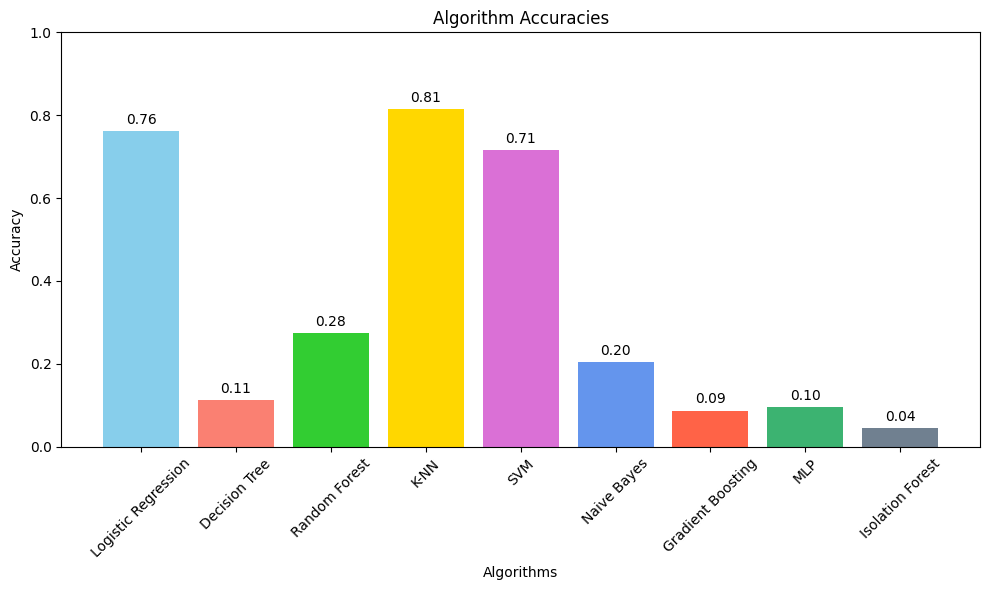

In [33]:
# @title Visualizing the ACC of 9 models
import matplotlib.pyplot as plt

# Your existing data (including GNN)
algorithms = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'K-NN', 'SVM', 'Naive Bayes',
              'Gradient Boosting', 'MLP', 'Isolation Forest']
accuracies = [0.7625, 0.1125, 0.275, 0.815, 0.715, 0.205, 0.0875, 0.095, 0.045]

# Create a colorful bar chart
plt.figure(figsize=(10, 6))
colors = ['skyblue', 'salmon', 'limegreen', 'gold', 'orchid', 'cornflowerblue', 'tomato',
          'mediumseagreen', 'slategray', 'royalblue']
bars = plt.bar(algorithms, accuracies, color=colors)
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.title('Algorithm Accuracies')
plt.ylim(0, 1)  # Set y-axis limit
plt.xticks(rotation=45)

# Annotate each bar with its accuracy value
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{acc:.2f}', ha='center', va='bottom')

plt.tight_layout()

# Save the plot (optional)
plt.savefig('algorithm_accuracies.png')

# Show the plot
plt.show()
